In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
# Load the dataset
try:
    df = pd.read_csv('C:/Users/ADMIN/Downloads/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=False)
    print("Dataset loaded successfully!")
    print(df.shape)
except FileNotFoundError:
    print("Dataset file not found. Please ensure you've downloaded it correctly.")

df.info()

In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("Loan Status Distribution:")
print(df['loan_status'].value_counts())

Loan Status Distribution:
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


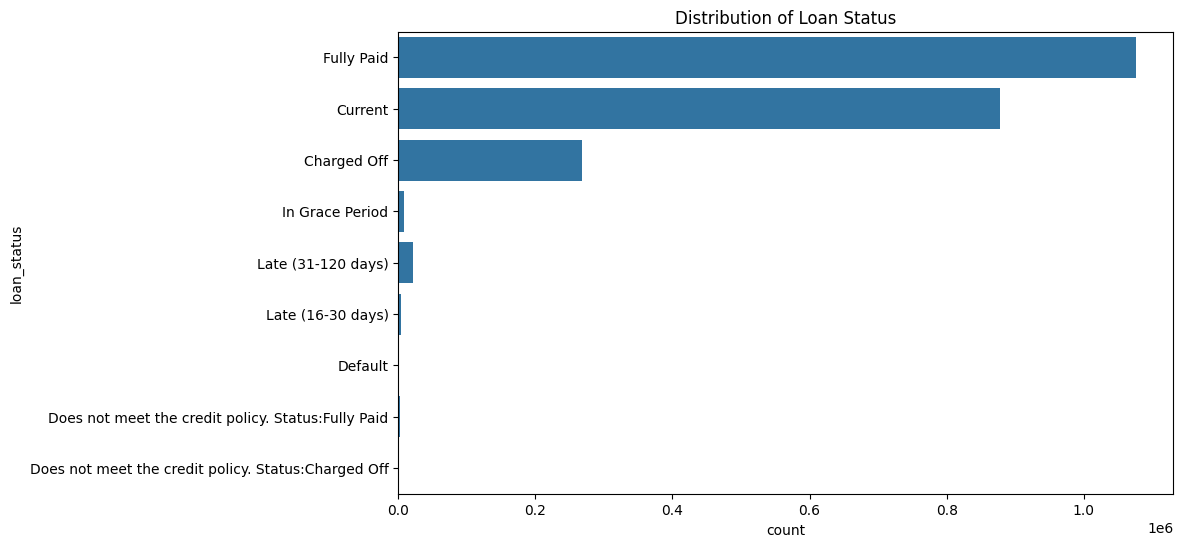

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df['loan_status'])
plt.title('Distribution of Loan Status')
plt.show()


In [ ]:
# We consider 'Charged Off' as a default (1)
# We consider 'Fully Paid' as a non-default (0)
df['is_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else (0 if x == 'Fully Paid' else -1))


In [ ]:
df['is_default']

0          0
1          0
2          0
3         -1
4          0
          ..
2260696   -1
2260697    1
2260698   -1
2260699   -1
2260700   -1
Name: is_default, Length: 2260701, dtype: int64

In [ ]:
# Filter out loans that are not yet completed (e.g., 'Current', 'In Grace Period')
df_model = df[df['is_default'] != -1].copy()
df_model['is_default'] = df_model['is_default'].astype(int)



New Target Variable 'is_default' Distribution:
is_default
0    1076751
1     268559
Name: count, dtype: int64


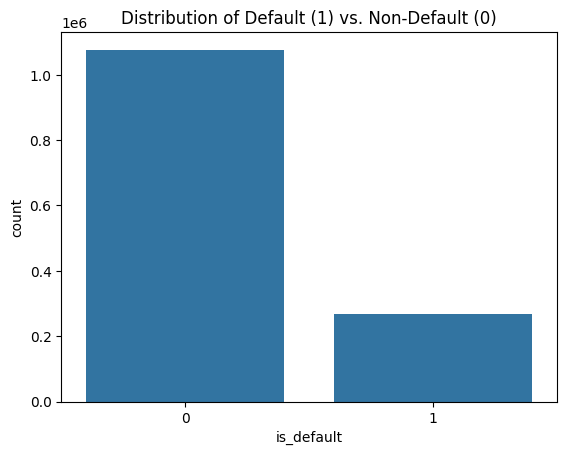

In [ ]:
# Check the new target variable distribution
print("\nNew Target Variable 'is_default' Distribution:")
print(df_model['is_default'].value_counts())
sns.countplot(x=df_model['is_default'])
plt.title('Distribution of Default (1) vs. Non-Default (0)')
plt.show()

In [ ]:
static_numeric_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti']
static_categorical_features = ['grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']

In [ ]:
text_features = ['purpose', 'title']


In [ ]:
selected_features = static_numeric_features + static_categorical_features + text_features + ['is_default']
df_clean = df_model[selected_features].copy()

In [ ]:
print("Missing values before cleaning:")
print(df_clean.isnull().sum())

Missing values before cleaning:
loan_amnt                  0
int_rate                   0
installment                0
annual_inc                 0
dti                      374
grade                      0
emp_length             78511
home_ownership             0
verification_status        0
purpose                    0
purpose                    0
title                  16660
is_default                 0
dtype: int64


In [ ]:
df_clean['title'].fillna('', inplace=True)
df_clean.dropna(inplace=True) # Drop rows with missing values in other columns

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13676\1736440729.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['title'].fillna('', inplace=True)


In [ ]:
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())
print(f"\nShape of cleaned data: {df_clean.shape}")


Missing values after cleaning:
loan_amnt              0
int_rate               0
installment            0
annual_inc             0
dti                    0
grade                  0
emp_length             0
home_ownership         0
verification_status    0
purpose                0
purpose                0
title                  0
is_default             0
dtype: int64

Shape of cleaned data: (1266782, 13)


In [ ]:
print(df_clean.columns[df_clean.columns.duplicated()])


Index(['purpose'], dtype='object')


In [ ]:
df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]


In [ ]:
df_clean['text_input'] = df_clean['title'] + ' ' + df_clean['purpose']

In [ ]:
text_data = df_clean['text_input'].astype(str)
target = df_clean['is_default']

In [ ]:
VOCAB_SIZE = 10000  
MAX_LEN = 50       
OOV_TOKEN = "<OOV>" 


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(text_data)

sequences = tokenizer.texts_to_sequences(text_data)

padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print("Example original text:", text_data.iloc[0])
print("Example sequence:", sequences[0])
print("Example padded sequence:", padded_sequences[0])

Example original text: Debt consolidation debt_consolidation
Example sequence: [3, 2, 3, 2]
Example padded sequence: [3 2 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# 2. Static Data Pre-processing
static_data = df_clean[static_numeric_features + static_categorical_features]

# Create pre-processing pipelines for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Use ColumnTransformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, static_numeric_features),
        ('cat', categorical_transformer, static_categorical_features)
    ])


In [ ]:
# Splitting static data and padded sequences together
X_static = static_data
X_text = padded_sequences
y = target

# First split: 80% for training, 20% for testing
X_static_train, X_static_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_static, X_text, y, test_size=0.2, random_state=42, stratify=y)

# Fit and transform the static training data
X_static_train_processed = preprocessor.fit_transform(X_static_train)
# Only transform the test data using the fitted preprocessor
X_static_test_processed = preprocessor.transform(X_static_test)


print("Training data shapes:")
print(X_static_train_processed.shape, X_text_train.shape, y_train.shape)
print("\nTest data shapes:")
print(X_static_test_processed.shape, X_text_test.shape, y_test.shape)

Training data shapes:
(1013425, 46) (1013425, 50) (1013425,)

Test data shapes:
(253357, 46) (253357, 50) (253357,)


In [ ]:
# Take a random sample of 100 rows from your static training data
background_sample = X_static_train.sample(100, random_state=42)

# Save this sample to a CSV file in your main project directory
background_sample.to_csv('shap_background_data.csv', index=False)

print("Background data for SHAP saved successfully!")

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout

# --- Branch 1: Text Processing ---
EMBEDDING_DIM = 64
text_input = Input(shape=(MAX_LEN,), name='text_input')
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(text_input)
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
text_branch = Dense(32, activation='relu')(pooling_layer)

# --- Branch 2: Static Data Processing ---
# The shape is determined by our preprocessor's output
static_input = Input(shape=(X_static_train_processed.shape[1],), name='static_input')
static_branch = Dense(64, activation='relu')(static_input)
static_branch = Dropout(0.3)(static_branch)
static_branch = Dense(32, activation='relu')(static_branch)

# --- Concatenate Branches ---
combined = Concatenate()([text_branch, static_branch])
combined = Dense(32, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(1, activation='sigmoid', name='output')(combined) # Sigmoid for binary classification

# --- Create and Compile Model ---
model = Model(inputs=[text_input, static_input], outputs=output)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 64)    │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 46, 128)   │     41,088 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      3,008 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 692,417 (2.64 MB)

 Trainable params: 692,417 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# For handling class imbalance
from sklearn.utils import class_weight

# Set some visual styles
sns.set_style('whitegrid')
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


In [ ]:
# Calculate class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(len(weights))}

print(f"Class Weights: {class_weights}")

# Set up EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)

# Train the model
history = model.fit(
    x={'text_input': X_text_train, 'static_input': X_static_train_processed},
    y=y_train,
    epochs=25,
    batch_size=256,
    validation_split=0.15, # Use part of the training data for validation
    callbacks=[early_stopping],
    class_weight=class_weights,
    verbose=1
)

Class Weights: {0: np.float64(0.6213641224107401), 1: np.float64(2.559916843908033)}
Epoch 1/25
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 296s 86ms/step - accuracy: 0.6200 - auc: 0.6848 - loss: 0.6395 - val_accuracy: 0.6572 - val_auc: 0.7115 - val_loss: 0.6142
Epoch 2/25
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 284s 84ms/step - accuracy: 0.6406 - auc: 0.7050 - loss: 0.6279 - val_accuracy: 0.6403 - val_auc: 0.7128 - val_loss: 0.6272
Epoch 3/25
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 293s 87ms/step - accuracy: 0.6408 - auc: 0.7096 - loss: 0.6243 - val_accuracy: 0.6465 - val_auc: 0.7117 - val_loss: 0.6211
Epoch 4/25
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 292s 87ms/step - accuracy: 0.6414 - auc: 0.7110 - loss: 0.6227 - val_accuracy: 0.6348 - val_auc: 0.7103 - val_loss: 0.6283
Epoch 5/25
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 287s 85ms/step - accuracy: 0.6442 - auc: 0.7158 - loss: 0.6183 - val_accuracy: 0.6489 - val_auc: 0.7093 - val_loss: 0.6173
Epoch 6/25
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 280s 83ms/step - accuracy: 0.6450 - auc: 0.7178 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # Set the y-axis range to [0,1] for better readability
plt.title("Model Training History")
plt.show()

In [ ]:
# Evaluate the model on the unseen test set
results = final_model.evaluate(
    {'text_input': X_text_test, 'static_input': X_static_test_processed},
    y_test,
    verbose=0
)

print("--- Test Set Evaluation ---")
for name, value in zip(final_model.metrics_names, results):
    print(f"{name}: {value:.4f}")

In [ ]:
# Get prediction probabilities
y_pred_proba = final_model.predict({
    'text_input': X_text_test, 
    'static_input': X_static_test_processed
}).ravel()

# Convert probabilities to class labels using a 0.5 threshold
y_pred_class = (y_pred_proba > 0.5).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_class, target_names=['Non-Default (0)', 'Default (1)']))

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()  

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'], 
            yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

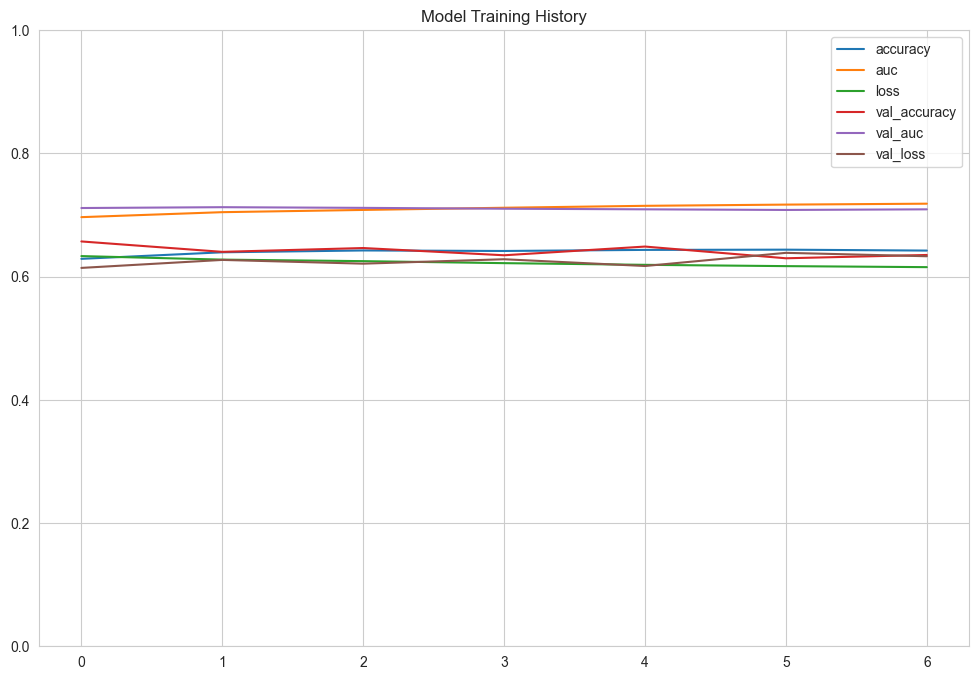


Test Set Evaluation:
loss: 0.6262
compile_metrics: 0.6405
7918/7918 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step

Classification Report:
                 precision    recall  f1-score   support

Non-Default (0)       0.89      0.63      0.74    203872
    Default (1)       0.31      0.67      0.42     49485

       accuracy                           0.64    253357
      macro avg       0.60      0.65      0.58    253357
   weighted avg       0.78      0.64      0.68    253357



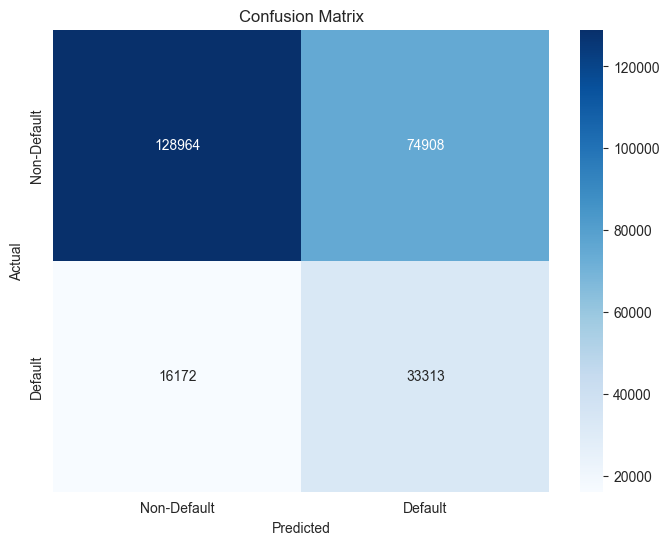

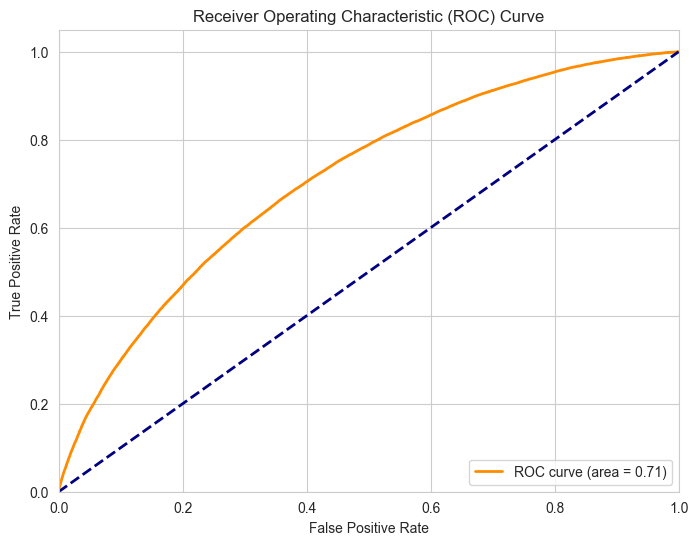

In [ ]:
# # 1. Plot training history
# pd.DataFrame(history.history).plot(figsize=(12, 8))
# plt.grid(True)
# plt.gca().set_ylim(0, 1) # set the y-axis range to [0,1]
# plt.title("Model Training History")
# plt.show()

# # 2. Evaluate on the test set
# results = model.evaluate(
#     {'text_input': X_text_test, 'static_input': X_static_test_processed},
#     y_test,
#     verbose=0
# )
# print("\nTest Set Evaluation:")
# for name, value in zip(model.metrics_names, results):
#     print(f"{name}: {value:.4f}")

# # 3. Make predictions
# y_pred_proba = model.predict({'text_input': X_text_test, 'static_input': X_static_test_processed}).ravel()
# y_pred_class = (y_pred_proba > 0.5).astype(int) # Using 0.5 as the threshold

# # 4. Classification Report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred_class, target_names=['Non-Default (0)', 'Default (1)']))

# # 5. Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_class)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # 6. ROC Curve and AUC Score
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
!pip install -q -U keras-tuner


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import keras_tuner as kt

def build_model(hp):
    # --- Branch 1: Text Processing ---
    text_input = Input(shape=(MAX_LEN,), name='text_input')
    embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(text_input)
    
    # TUNE: Number of filters in the Conv1D layer
    hp_cnn_filters = hp.Int('cnn_filters', min_value=64, max_value=256, step=32)
    conv_layer = Conv1D(filters=hp_cnn_filters, kernel_size=5, activation='relu')(embedding_layer)
    
    pooling_layer = GlobalMaxPooling1D()(conv_layer)
    
    # TUNE: Number of units in the dense layer after text processing
    hp_text_dense_units = hp.Int('text_dense_units', min_value=16, max_value=64, step=16)
    text_branch = Dense(units=hp_text_dense_units, activation='relu')(pooling_layer)

    # --- Branch 2: Static Data Processing ---
    static_input = Input(shape=(X_static_train_processed.shape[1],), name='static_input')
    
    # TUNE: Number of units in the first dense layer for static data
    hp_static_dense_units_1 = hp.Int('static_dense_units_1', min_value=32, max_value=128, step=32)
    static_branch = Dense(units=hp_static_dense_units_1, activation='relu')(static_input)

    # TUNE: Dropout rate for static data
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    static_branch = Dropout(hp_dropout_1)(static_branch)
    
    static_branch = Dense(units=hp_text_dense_units, activation='relu')(static_branch) # Re-use the tuned value for symmetry

    # --- Concatenate Branches ---
    combined = Concatenate()([text_branch, static_branch])
    
    # TUNE: Number of units in the final dense layer
    hp_final_dense_units = hp.Int('final_dense_units', min_value=16, max_value=64, step=16)
    combined = Dense(units=hp_final_dense_units, activation='relu')(combined)
    
    # TUNE: Dropout rate before the output layer
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
    combined = Dropout(hp_dropout_2)(combined)
    
    output = Dense(1, activation='sigmoid', name='output')(combined)
    
    model = Model(inputs=[text_input, static_input], outputs=output)

    # TUNE: The learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_auc", direction="max"), # We want to maximize the validation AUC
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='loan_default_tuning'
)

# Create a callback to stop training early if the validation loss doesn't improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Start the search!
# This process will take a significant amount of time.
tuner.search(
    x={'text_input': X_text_train, 'static_input': X_static_train_processed},
    y=y_train,
    epochs=50, # The tuner will manage the epochs up to max_epochs
    validation_split=0.15,
    callbacks=[stop_early],
    class_weight=class_weights # Don't forget the class weights!
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
Optimal number of filters in Conv1D layer: {best_hps.get('cnn_filters')}
Optimal number of units in text dense layer: {best_hps.get('text_dense_units')}
Optimal number of units in static dense layer 1: {best_hps.get('static_dense_units_1')}
Optimal dropout rate for static branch: {best_hps.get('dropout_1'):.2f}
Optimal number of units in final dense layer: {best_hps.get('final_dense_units')}
Optimal dropout rate for final branch: {best_hps.get('dropout_2'):.2f}
Optimal learning rate for the optimizer: {best_hps.get('learning_rate')}
""")

Trial 30 Complete [01h 48m 32s]
val_auc: 0.7047780156135559

Best val_auc So Far: 0.7138585448265076
Total elapsed time: 1d 16h 06m 09s

The hyperparameter search is complete. 
Optimal number of filters in Conv1D layer: 96
Optimal number of units in text dense layer: 64
Optimal number of units in static dense layer 1: 128
Optimal dropout rate for static branch: 0.20
Optimal number of units in final dense layer: 48
Optimal dropout rate for final branch: 0.40
Optimal learning rate for the optimizer: 0.0001



In [ ]:
# Build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model on the full training data
history = best_model.fit(
    x={'text_input': X_text_train, 'static_input': X_static_train_processed},
    y=y_train,
    epochs=50, 
    batch_size=256  ,
    validation_split=0.15,
    callbacks=[stop_early],
    class_weight=class_weights
)

print("\n--- Final Evaluation on Test Set with Best Model ---")

# Evaluate the final, tuned model on the unseen test set
final_results = best_model.evaluate(
    {'text_input': X_text_test, 'static_input': X_static_test_processed},
    y_test,
    verbose=0
)

print("Tuned Test Set Evaluation:")
for name, value in zip(best_model.metrics_names, final_results):
    print(f"{name}: {value:.4f}")

Epoch 1/50
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 288s 84ms/step - accuracy: 0.6186 - auc: 0.6714 - loss: 0.6464 - val_accuracy: 0.6169 - val_auc: 0.7098 - val_loss: 0.6366
Epoch 2/50
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 286s 85ms/step - accuracy: 0.6294 - auc: 0.7021 - loss: 0.6296 - val_accuracy: 0.6247 - val_auc: 0.7116 - val_loss: 0.6358
Epoch 3/50
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 285s 85ms/step - accuracy: 0.6345 - auc: 0.7062 - loss: 0.6255 - val_accuracy: 0.6368 - val_auc: 0.7121 - val_loss: 0.6279
Epoch 4/50
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 283s 84ms/step - accuracy: 0.6388 - auc: 0.7077 - loss: 0.6244 - val_accuracy: 0.6443 - val_auc: 0.7124 - val_loss: 0.6185
Epoch 5/50
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 281s 84ms/step - accuracy: 0.6404 - auc: 0.7094 - loss: 0.6234 - val_accuracy: 0.6434 - val_auc: 0.7125 - val_loss: 0.6222
Epoch 6/50
3365/3365 ━━━━━━━━━━━━━━━━━━━━ 286s 85ms/step - accuracy: 0.6413 - auc: 0.7106 - loss: 0.6221 - val_accuracy: 0.6369 - val_auc: 0.7121 - val_loss: 0.6268
Epoch 7/50

In [ ]:
# Build the final model with the best hyperparameters found by the tuner
final_model = tuner.hypermodel.build(best_hps)

# Train this model on the ENTIRE training set for a suitable number of epochs
# We no longer need a validation_split here
history = final_model.fit(
    x={'text_input': X_text_train, 'static_input': X_static_train_processed},
    y=y_train,
    epochs=20, 
    batch_size=256,
    class_weight=class_weights,
    callbacks=[stop_early] 
)

Epoch 1/20
3959/3959 ━━━━━━━━━━━━━━━━━━━━ 287s 71ms/step - accuracy: 0.6273 - auc: 0.6764 - loss: 0.6442
Epoch 2/20


c:\python\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,auc,loss
  current = self.get_monitor_value(logs)


3959/3959 ━━━━━━━━━━━━━━━━━━━━ 273s 69ms/step - accuracy: 0.6336 - auc: 0.7035 - loss: 0.6275
Epoch 3/20
3959/3959 ━━━━━━━━━━━━━━━━━━━━ 339s 86ms/step - accuracy: 0.6358 - auc: 0.7064 - loss: 0.6255
Epoch 4/20
3959/3959 ━━━━━━━━━━━━━━━━━━━━ 442s 112ms/step - accuracy: 0.6389 - auc: 0.7087 - loss: 0.6244
Epoch 5/20
3959/3959 ━━━━━━━━━━━━━━━━━━━━ 512s 129ms/step - accuracy: 0.6401 - auc: 0.7096 - loss: 0.6232
Epoch 6/20
3959/3959 ━━━━━━━━━━━━━━━━━━━━ 673s 170ms/step - accuracy: 0.6407 - auc: 0.7115 - loss: 0.6218
Epoch 7/20
3959/3959 ━━━━━━━━━━━━━━━━━━━━ 441s 109ms/step - accuracy: 0.6400 - auc: 0.7108 - loss: 0.6216
Epoch 8/20
3959/3959 ━━━━━━━━━━━━━━━━━━━━ 336s 85ms/step - accuracy: 0.6422 - auc: 0.7135 - loss: 0.6192
Epoch 9/20
3959/3959 ━━━━━━━━━━━━━━━━━━━━ 370s 93ms/step - accuracy: 0.6415 - auc: 0.7154 - loss: 0.6188
Epoch 10/20
3959/3959 ━━━━━━━━━━━━━━━━━━━━ 380s 96ms/step - accuracy: 0.6406 - auc: 0.7173 - loss: 0.6176
Epoch 11/20
3959/3959 ━━━━━━━━━━━━━━━━━━━━ 418s 105ms/step - 

In [ ]:
import joblib

# 1. Save the trained Keras model
final_model.save('loan_default_model1.h5')

In [ ]:
# 2. Save the text tokenizer
joblib.dump(tokenizer, 'tokenizer1.pkl')

['tokenizer1.pkl']

In [ ]:
# 3. Save the static data preprocessor
joblib.dump(preprocessor, 'preprocessor1.pkl')
print("Model and processing artifacts saved successfully!")

Model and processing artifacts saved successfully!


In [ ]:
import joblib
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Define the Prediction Function ---

def predict_loan_default(new_data):
    """
    Loads artifacts and predicts default probability for new loan data.
    
    Args:
        new_data (pd.DataFrame): A DataFrame with one or more rows of new loan applications.
                                 Must contain the same columns as the training data.
                                 
    Returns:
        np.ndarray: An array of prediction probabilities.
    """
    # 1. Load the saved artifacts
    model = load_model(r'D:/DL_Project/loan_default_model1.h5')
    tokenizer = joblib.load(r'D:/DL_Project/tokenizer1.pkl')
    preprocessor = joblib.load(r'D:/DL_Project/preprocessor1.pkl')
    
    # 2. Prepare the input data
    # Combine text features for tokenization
    new_text_data = new_data['title'].fillna('') + ' ' + new_data['purpose']
    
    # Select static features for preprocessing
    static_features_cols = preprocessor.feature_names_in_
    new_static_data = new_data[static_features_cols]
    
    # 3. Process the data using the loaded artifacts
    # Process text data
    new_sequences = tokenizer.texts_to_sequences(new_text_data)
    padded_new_sequences = pad_sequences(new_sequences, maxlen=50, padding='post', truncating='post')
    
    # Process static data
    processed_new_static = preprocessor.transform(new_static_data)
    
    # 4. Make a prediction
    prediction_proba = model.predict({
        'text_input': padded_new_sequences,
        'static_input': processed_new_static
    })
    
    return prediction_proba

In [ ]:
# Create a sample DataFrame mimicking a new loan application
# NOTE: The values here are for demonstration purposes.
sample_application = pd.DataFrame({
    'loan_amnt': [15000],
    'int_rate': [12.5],
    'installment': [501.77],
    'annual_inc': [75000],
    'dti': [18.5],
    'grade': ['C'],
    'emp_length': ['10+ years'],
    'home_ownership': ['MORTGAGE'],
    'verification_status': ['Verified'],
    'purpose': ['debt_consolidation'],
    'title': ['Debt Consolidation Loan']
})

# Get the prediction
predicted_probability = predict_loan_default(sample_application)

print(f"Sample Loan Application Data:\n{sample_application.T}\n")
print(f"Predicted Default Probability: {predicted_probability[0][0] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
Sample Loan Application Data:
                                           0
loan_amnt                              15000
int_rate                                12.5
installment                           501.77
annual_inc                             75000
dti                                     18.5
grade                                      C
emp_length                         10+ years
home_ownership                      MORTGAGE
verification_status                 Verified
purpose                   debt_consolidation
title                Debt Consolidation Loan

Predicted Default Probability: 44.60%


In [ ]:
# --- Create SHAP Explainer (runs once at startup) ---

# Get the list of categorical and numerical feature names from the preprocessor
categorical_features = preprocessor.named_transformers_['cat'].feature_names_in_
numerical_features = preprocessor.named_transformers_['num'].feature_names_in_

# Create a dummy DataFrame with one row of placeholder data
background_data = {}
for col in numerical_features:
    background_data[col] = [0]  # Placeholder for numerical columns
for col in categorical_features:
    background_data[col] = ['missing'] # Placeholder for categorical columns

background_static_df = pd.DataFrame(background_data)

# Now, transform this correctly-typed DataFrame
background_static = preprocessor.transform(background_static_df)
background_text = np.zeros((1, 50))

# Define a prediction function that SHAP can use
def predict_for_shap(x_static):
    num_samples = x_static.shape[0]
    text_data_tiled = np.tile(background_text, (num_samples, 1))
    return model.predict({'text_input': text_data_tiled, 'static_input': x_static})

explainer = shap.KernelExplainer(predict_for_shap, background_static)
print("SHAP explainer created successfully!")

NameError: name 'shap' is not defined